In [95]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')

In [96]:
figure3_outpath = '../../../Figures/Figure 3/'

In [97]:
#read in cleaned combined data
NewDatasetCombine = pd.read_csv('../../../Data/cleanedData/CombinedCleanedDatasets.csv', low_memory=False)

#alter chromosome notation to be compatible with bed files
NewDatasetCombine['chromosome'] = NewDatasetCombine['chromosome'].replace('chr24','chrY')
NewDatasetCombine['chromosome'] = NewDatasetCombine['chromosome'].replace('chr23','chrX')

#get dataframe of unique guide/gene combinations across datasets
UniqueNewDatasetCombine = NewDatasetCombine[['Target Gene Symbol',
                                             'chromosome',
                                             'sgRNA Context Sequence',
                                             'sgRNA \'Cut\' Position']].drop_duplicates()
UniqueNewDatasetCombine

,Target Gene Symbol,chromosome,sgRNA Context Sequence,sgRNA 'Cut' Position
0,LARS2,chr3,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0
3,COQ2,chr4,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0
6,IGBP1,chrX,AATAAAAAAAAAAAGTGATCAGTTTGGAAA,70133000.0
9,YEATS4,chr12,AAAAAAAAAAAAAATTAACGTGCCAGGGGC,69360661.0
12,COPS3,chr17,AAAAAAAAAAAAAGCCGTGTGAGCTGGCGG,17280422.0
...,...,...,...,...
257411,WDR11,chr10,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0
257412,WDR11,chr10,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0
257413,WDR11,chr10,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0
257414,WDR11,chr10,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0


In [98]:
#divide unique guide/gene combinations into a separate file for each gene
for grp, each_csv in UniqueNewDatasetCombine.groupby(['Target Gene Symbol','chromosome']):
    each_csv[['sgRNA Context Sequence', 'sgRNA \'Cut\' Position']].to_csv(f"../../../Data/DHS/perGeneGuidePositions/{grp[1]}_{grp[0]}.csv",
                                                                          index = False)

### Download DHS files and manually combine replicates

Download bed narrowPeak files with peaks called at an FDR cutoff of 5%:

- K562s: https://www.encodeproject.org/files/ENCFF638QFS/, https://www.encodeproject.org/files/ENCFF784DIM/
- HCT116s: https://www.encodeproject.org/files/ENCFF547FKC/, https://www.encodeproject.org/files/ENCFF527GRA/
- A549s: https://www.encodeproject.org/files/ENCFF310LGE/, https://www.encodeproject.org/files/ENCFF410KIB/

The two replicates for each cell line were merged using the following commands:

cat replicate1.bed replicate2.bed | sort -k1,1 -k2,2n > combined_peaks.bed \
bedtools merge -i combined_peaks.bed > merged_peaks.bed

In [99]:
#read in merged peaks for each cell line

merged_peaks_A549 = []
with open("../../../Data/DHS/mergedPeaks/merged_peaks_a549.bed")as f:
    for line in f:
        merged_peaks_A549.append(line.strip().split())

merged_peaks_HCT116 = []
with open("../../../Data/DHS/mergedPeaks/merged_peaks_hct116.bed")as f:
    for line in f:
        merged_peaks_HCT116.append(line.strip().split())

merged_peaks_K562 = []
with open("../../../Data/DHS/mergedPeaks/merged_peaks_k562.bed")as f:
    for line in f:
        merged_peaks_K562.append(line.strip().split())

In [100]:
merged_peaks_A549 = pd.DataFrame(merged_peaks_A549)
merged_peaks_HCT116 = pd.DataFrame(merged_peaks_HCT116)
merged_peaks_K562 = pd.DataFrame(merged_peaks_K562)

In [101]:
for grp, each_csv in merged_peaks_A549.groupby(0):
    each_csv = each_csv.rename(columns = {1: 'start', 2: 'end'})
    each_csv[['start','end']].to_csv(f"../../../Data/DHS/perChromosomePeaks/A549_{grp}.csv", index = False)
for grp, each_csv in merged_peaks_HCT116.groupby(0):
    each_csv = each_csv.rename(columns = {1: 'start', 2: 'end'})
    each_csv[['start','end']].to_csv(f"../../../Data/DHS/perChromosomePeaks/HCT116_{grp}.csv", index = False)
for grp, each_csv in merged_peaks_K562.groupby(0):
    each_csv = each_csv.rename(columns = {1: 'start', 2: 'end'})
    each_csv[['start','end']].to_csv(f"../../../Data/DHS/perChromosomePeaks/K562_{grp}.csv", index = False)

### Compute Peak Overlap

In [102]:
#Functions
def isInRange(n, tbl):
    #https://stackoverflow.com/questions/9019581/what-does-numpy-apply-along-axis-perform-exactly
    #https://stackoverflow.com/questions/71377816/check-if-value-is-between-two-values-in-numpy-array
    # n: is sgRNA location in the tiling/phenotypic dataset (need to subtract 1 because CRISPick is 1-based and bed files are 0-based)
    # tbl: numpy file of dataframe of bigbed with chro, start, and end of peak filtered_peak_file.to_numpy()
    #apply_along_axis applies the supplied function along 1D slices of the input array, 
    #with the slices taken along the axis you specify. 
    return sum(np.apply_along_axis(lambda row: row[0] <= n <= row[1], 1, tbl)\
        .tolist())

def dhs_peak_overlap(actual_tiling_gene , dhs_chromo_txt, sgrna_location_col):
    # This function find whether guide overlaps with a peak in one chromosome 
    
    # actual_tiling: CRISPRi data (or any CRISPR data) with at least three columns 
    #                       [a location to indicate sgRNA, Gene name, Chromosome]
    #                       Note this DOES NOT require unique sgRNA location 
    # dhs_chromo_txt: ATAC seq from ENCODE in bigBed format and read through pyBigWig
    # chrom: string of chromosome such as 'chr1'
    # sgrna_location_col: string of column for sgRNA location
    
    # returns a dataframe, same as the actual_tilling but with an additional column overlap with peak to indicate 
    # whether theres an overlap between start and end of a peak and sgRNA location for one chromosome
    
    #----------------------------------------------------------------------------------------------------
        
    # select unique pam coord and chr and gene - remove duplicate 
    # tiling_lib: CRISPRi data (or any CRISPR data) with at least three columns 
    #                       [a location to indicate sgRNA, Gene name, Chromosome]
    #                       Note this should has unique sgRNA location 
    tiling_lib = actual_tiling_gene.copy()
    
    # change from string to int
    tiling_lib[sgrna_location_col] = list(map(int,tiling_lib[sgrna_location_col]))
    
    #obtain the smallest pam coord in a specific chromosome
    smallest_pam_coord = tiling_lib[sgrna_location_col].min()
    #obtain the largest pam coord in a specific chromosome
    largestest_pam_coord = tiling_lib[sgrna_location_col].max()
    
    #subset chrom number and having the end coord to be larger than the smallest pam coord
    
    # Retrieving bigBed entries in https://github.com/deeptools/pyBigWig explains
    # filtered_peak_file returns a list of tuple of (Start position in chromosome, End position in chromosome)
    # filtered_peak_file = dhs_chromo_txt.entries(chrom, smallest_pam_coord, largestest_pam_coord, withString=False) 
    filtered_peak_file = dhs_chromo_txt[(dhs_chromo_txt["start"] >= int(smallest_pam_coord)) & (dhs_chromo_txt["end"] <= int(largestest_pam_coord))].copy()
    
    # only kept unique peaks and make it into dataframe because of https://www.biostars.org/p/464618/
    # filtered_peak_file = pd.DataFrame(set(filtered_peak_file))
    filtered_peak_file = filtered_peak_file.drop_duplicates(subset = ["start", "end"])
    
    if len(filtered_peak_file) == 0:
        print('This gene does not has any peaks in DHS')
        tiling_lib.loc[:, 'overlap with peak'] = 0
    else:
    # iterating over every single sgRNA location in the tiling library/a dataset with phenotypic data
        peak_list = [isInRange(x, filtered_peak_file.to_numpy()) 
                     for x in np.nditer(tiling_lib[sgrna_location_col].to_numpy())]  

        #https://stackoverflow.com/questions/32573452/settingwithcopywarning-even-when-using-locrow-indexer-col-indexer-value
        tiling_lib.loc[:, 'overlap with peak'] = peak_list

    return tiling_lib
def get_gene_chr_combo(library_path):
    dir_list = os.listdir(library_path)
    file_split_remove_csv = [file.split('.')[0] for file in dir_list if file.endswith('.csv')]# remove files that doesnt end with csv
    files_combo = [file.split('_') for file in file_split_remove_csv]
    return(files_combo)

def dhs_all_genes(file_combo,library_gene_path, dhs_chrom_path, sgrna_location_col = 'sgRNA \'Cut\' Position'):
    library_dhs = pd.DataFrame()
    for comb in tqdm(file_combo ,desc='number of gene symbol'):
        print(comb)
        chrom_num = comb[0]
        gene = comb[1]
        chr_gene_library = pd.read_csv(f'{library_gene_path}{chrom_num}_{gene}.csv')
        chr_gene_library['chromosome'] = chrom_num
        chr_gene_library['Target Gene Symbol'] = gene
        chr_dhs = pd.read_csv(f'{dhs_chrom_path}{chrom_num}.csv')
        chr_dhs['chromosome'] = chrom_num
        gene_check = dhs_peak_overlap(chr_gene_library , chr_dhs, sgrna_location_col = sgrna_location_col)
        library_dhs = pd.concat([library_dhs,gene_check])
    return library_dhs

In [103]:
#read in guide positions
perGeneGuidePosition_filepath = '../../../Data/DHS/perGeneGuidePositions/'

CRISPRi_fileCombo = get_gene_chr_combo(perGeneGuidePosition_filepath)
len(CRISPRi_fileCombo)

469

In [104]:
CRISPRiFiles_DHS_A549 = dhs_all_genes(CRISPRi_fileCombo,perGeneGuidePosition_filepath, "../../../Data/DHS/perChromosomePeaks/A549_")

number of gene symbol:   2%|▎                   | 8/469 [00:00<00:06, 71.62it/s]

['chr14', 'HAUS4']
['chr11', 'SF3B2']
['chr7', 'MRPS24']
['chr20', 'DDX27']
['chr9', 'DCTN3']
['chr12', 'POP5']
['chr8', 'POLR2K']
['chr19', 'MRPL34']
['chr11', 'RAD9A']
['chr2', 'MRPL19']
['chr1', 'FDPS']
['chr1', 'HEATR1']
['chr17', 'COX10']
['chr7', 'TRRAP']
['chr13', 'ARGLU1']


number of gene symbol:   5%|▉                  | 24/469 [00:00<00:06, 72.02it/s]

['chr13', 'TM9SF2']
['chr17', 'C17orf49']
['chr15', 'MFAP1']
['chr16', 'RSL1D1']
['chr6', 'RPL7L1']
['chr6', 'DHX16']
['chr4', 'SDAD1']
['chr2', 'CHMP3']
['chr19', 'ZNF574']
['chr1', 'MTOR']
['chr2', 'DYNC1I2']
['chr5', 'RPS14']
['chr10', 'EIF3A']
['chr14', 'YY1']
['chr7', 'MRPS33']
['chr11', 'TAF10']


number of gene symbol:   9%|█▌                 | 40/469 [00:00<00:06, 70.54it/s]

['chr20', 'CSE1L']
['chr1', 'SF3B4']
['chr1', 'CCT3']
['chr5', 'ZMAT2']
['chr8', 'ATP6V1H']
['chr19', 'ILF3']
['chr7', 'GET4']
['chr15', 'KNL1']
['chr12', 'GCN1']
['chr2', 'NCAPH']
['chr6', 'RPP40']
['chr1', 'VPS72']
['chr17', 'CDK12']
['chr1', 'PMVK']
['chr6', 'POLR1H']


number of gene symbol:  13%|██▍                | 59/469 [00:00<00:05, 81.42it/s]

['chr17', 'PIGS']
['chr7', 'SSBP1']
['chr2', 'MRPL33']
['chr11', 'RRM1']
['chr3', 'RPL14']
['chr1', 'CLSPN']
['chr4', 'COPS4']
['chr1', 'MCL1']
['chr17', 'CDC27']
['chr19', 'ERCC2']
['chr20', 'PRPF6']
['chr21', 'U2AF1']
This gene does not has any peaks in DHS
['chr14', 'C14orf178']
['chr19', 'CACTIN']
['chr1', 'TBCE']
['chr17', 'INTS2']
['chr18', 'TRAPPC8']
['chr17', 'LUC7L3']


number of gene symbol:  16%|███                | 77/469 [00:01<00:04, 79.66it/s]

['chr2', 'IMMT']
['chr13', 'TUBGCP3']
['chr2', 'SPC25']
['chr19', 'SPC24']
['chr2', 'XRCC5']
['chr20', 'DHX35']
['chr17', 'SIRT7']
['chr20', 'EIF6']
['chr2', 'WDR33']
['chr10', 'SMNDC1']
['chr6', 'RPF2']
['chr10', 'SEC24C']
['chr16', 'COG8']
['chr3', 'SEC13']
['chr3', 'EIF4G1']
['chr1', 'MRPS15']


number of gene symbol:  20%|███▊               | 94/469 [00:01<00:04, 79.55it/s]

['chr2', 'ERCC3']
['chr1', 'MRPS14']
['chr1', 'RPA2']
['chr2', 'PSMD1']
['chr11', 'INTS4']
['chr21', 'CCT8']
['chr1', 'CDC20']
['chr20', 'MYBL2']
['chr5', 'HMGCS1']
['chr1', 'RPL5']
['chr13', 'COG3']
['chr17', 'POLG2']
['chr10', 'RPS24']
['chr7', 'RFC2']
['chr5', 'BNIP1']
['chr20', 'RPN2']
['chr18', 'SKA1']


number of gene symbol:  24%|████▎             | 112/469 [00:01<00:04, 78.62it/s]

['chr2', 'CWC22']
['chr9', 'GNE']
['chr10', 'BMS1']
['chr10', 'POLR3A']
['chr3', 'TSEN2']
['chr7', 'DLD']
['chr9', 'DNLZ']
['chr17', 'MED9']
['chr14', 'EIF2B2']
['chr17', 'UTP6']
['chr1', 'INTS3']
['chr2', 'UGP2']
['chr1', 'PPP1R8']
['chr1', 'BCAS2']
['chr16', 'SRCAP']
['chr2', 'VPS54']


number of gene symbol:  26%|████▌             | 120/469 [00:01<00:04, 70.21it/s]

['chr17', 'BIRC5']
['chr11', 'ST3GAL4']
['chr14', 'PRMT5']
['chr14', 'TEDC1']
['chr17', 'NMT1']
['chr12', 'TIMELESS']
['chr20', 'SEC23B']
['chr5', 'WDR55']
['chr2', 'MRPL35']
['chr14', 'CEBPE']
This gene does not has any peaks in DHS
['chr12', 'TUBA1B']
['chr8', 'PUF60']
['chr2', 'NCL']


number of gene symbol:  29%|█████▎            | 137/469 [00:01<00:04, 75.23it/s]

['chr1', 'SNIP1']
['chr2', 'NRBP1']
['chr3', 'PSMD6']
['chr2', 'DDX18']
['chr5', 'MED7']
['chr5', 'TTC1']
['chr11', 'SART1']
['chr22', 'EIF3D']
['chr11', 'BUD13']
['chr6', 'LSM2']
['chr10', 'SUPV3L1']
['chr3', 'SRPRB']
['chr5', 'MRPS30']
['chr2', 'MRPS5']
['chr6', 'RPP21']
['chr5', 'DDX41']
['chr1', 'NUF2']
['chr20', 'DSN1']


number of gene symbol:  33%|█████▉            | 155/469 [00:02<00:03, 79.89it/s]

['chr7', 'ORC5']
['chr1', 'RPS27']
['chr17', 'PRPF8']
['chr6', 'TTK']
['chr7', 'EXOC4']
['chr14', 'MIS18BP1']
['chr9', 'NUP214']
['chr10', 'WDR11']
['chr9', 'IARS1']
['chr1', 'DAP3']
['chr5', 'MRPL22']
['chr10', 'TUBGCP2']
['chr10', 'SAR1A']
['chr17', 'RPL23']
['chr19', 'CARM1']
['chr7', 'POLR1F']


number of gene symbol:  37%|██████▌           | 172/469 [00:02<00:04, 73.72it/s]

['chr2', 'SRBD1']
['chr2', 'RAB1A']
['chr1', 'RPF1']
['chr12', 'ARL1']
['chr12', 'DDX23']
['chr1', 'GPN2']
['chr5', 'MRPS27']
['chr2', 'POLR1B']
['chr8', 'INTS8']
['chr5', 'PHAX']
['chr2', 'ITGAV']
['chr14', 'DYNC1H1']
['chr1', 'RABGGTB']
['chr6', 'MCM3']
['chr9', 'MRPS2']


number of gene symbol:  40%|███████▏          | 188/469 [00:02<00:03, 73.81it/s]

['chr1', 'SNRPE']
['chr14', 'PSMC1']
['chr1', 'PARS2']
['chr14', 'PSMB5']
['chr3', 'TRMT10C']
['chr3', 'MRPL3']
['chr1', 'PIGV']
['chr10', 'RPP30']
['chr17', 'NOL11']
['chr17', 'AATF']
['chr14', 'MED6']
['chr15', 'SNUPN']
['chr9', 'PSMB7']
['chr18', 'SEH1L']
['chr17', 'MYBBP1A']
['chr1', 'NVL']
['chr17', 'TBCD']


number of gene symbol:  43%|███████▊          | 204/469 [00:02<00:03, 69.89it/s]

['chr6', 'RPL10A']
['chr6', 'SYNCRIP']
['chr1', 'FH']
['chr11', 'DDB1']
['chr11', 'COPB1']
['chr12', 'CMAS']
['chr12', 'POLR3B']
['chr6', 'MRPS10']
['chr2', 'NBAS']
['chr17', 'RPL27']
['chr5', 'ZCCHC9']
['chr8', 'RPL8']
['chr14', 'PSMC6']
['chr15', 'RPAP1']


number of gene symbol:  47%|████████▍         | 221/469 [00:02<00:03, 74.42it/s]

['chr17', 'RPL19']
['chr1', 'MED18']
['chr7', 'RINT1']
['chr12', 'KRR1']
['chr16', 'PLK1']
['chr6', 'GTF2H4']
['chr4', 'NUP54']
['chr12', 'CIT']
['chr18', 'CEP192']
['chr6', 'SLC35A1']
['chr3', 'DBR1']
['chr12', 'NOP2']
['chr3', 'PSMD2']
['chr12', 'EP400']
['chr10', 'GBF1']
['chr3', 'GMPPB']


number of gene symbol:  49%|████████▊         | 229/469 [00:03<00:03, 69.67it/s]

['chr17', 'TOP2A']
['chr15', 'CEP152']
['chr12', 'ACTR6']
['chr19', 'PSMC4']
['chr15', 'KIF23']
['chr10', 'SMC3']
['chr4', 'ANAPC4']
['chr11', 'CKAP5']
['chr17', 'AURKB']
['chr11', 'EIF4G2']
['chr1', 'MRPL55']
['chr19', 'RPL36']
['chr1', 'ARF1']


number of gene symbol:  52%|█████████▍        | 246/469 [00:03<00:03, 70.07it/s]

['chr17', 'SRSF2']
['chr19', 'EIF3G']
['chr17', 'PSMB6']
['chr17', 'NSRP1']
['chr20', 'DYNLRB1']
['chr7', 'NUP205']
['chr12', 'CCT2']
['chr14', 'GEMIN2']
['chr2', 'RPL37A']
['chrX', 'IGBP1']
['chr15', 'TICRR']
['chr11', 'NUP160']
['chr2', 'POLR2D']
['chr11', 'SSRP1']
['chr20', 'TPX2']
['chr11', 'POLR2G']
['chr6', 'PRIM2']
['chr1', 'PRPF3']


number of gene symbol:  56%|██████████        | 263/469 [00:03<00:02, 71.04it/s]

['chr16', 'RBBP6']
['chr17', 'STAT5B']
['chr19', 'LSM4']
['chr14', 'SCFD1']
['chr19', 'EEF2']
['chr14', 'METTL17']
['chr16', 'NSMCE1']
['chr14', 'PSMA3']
['chr8', 'RPL7']
['chr15', 'RAD51']
['chr9', 'QSOX2']
['chr1', 'ZNHIT6']
['chr4', 'COQ2']


number of gene symbol:  59%|██████████▋       | 278/469 [00:03<00:03, 62.93it/s]

['chr12', 'MARS1']
['chr19', 'COX6B1']
['chr1', 'ILF2']
['chr3', 'TAMM41']
['chr1', 'DDOST']
['chr2', 'RRM2']
['chr1', 'TARS2']
['chr19', 'RPS19']
['chr6', 'PNISR']
['chr4', 'DHX15']
['chr16', 'PSMD7']
['chr16', 'CREBBP']


number of gene symbol:  61%|███████████       | 287/469 [00:03<00:02, 67.41it/s]

['chr17', 'MRPL45']
['chr2', 'NOP58']
['chr2', 'WDR75']
['chr5', 'CDC23']
['chr11', 'WEE1']
['chr8', 'ATP6V1B2']
['chr14', 'FNTB']
['chr4', 'UTP3']
['chr18', 'NAPG']
['chr3', 'EIF2B5']
['chr6', 'VARS2']
['chr1', 'DNTTIP2']
['chr1', 'ATP1A1']
['chr15', 'RSL24D1']
['chr3', 'MRPS25']
['chr3', 'GFM1']


number of gene symbol:  65%|███████████▋      | 303/469 [00:04<00:02, 71.71it/s]

['chr20', 'HM13']
['chr21', 'MRPL39']
['chr2', 'LRPPRC']
['chr5', 'SPDL1']
['chr1', 'RPL11']
['chr11', 'EIF3M']
['chr9', 'GOLGA1']
['chr17', 'NUP85']
['chrX', 'OGT']
['chr10', 'NOC3L']
['chr15', 'LEO1']
['chr22', 'RTCB']
['chr5', 'BDP1']
['chr12', 'RACGAP1']
['chr19', 'SNRNP70']
['chr10', 'UPF2']
['chr11', 'TAF6L']


number of gene symbol:  68%|████████████▎     | 321/469 [00:04<00:01, 77.75it/s]

['chr11', 'RPS13']
['chr7', 'PSMC2']
['chr17', 'RPL38']
['chr12', 'SNRPF']
['chr9', 'EXOSC2']
['chr11', 'HINFP']
['chr11', 'CWF19L2']
['chr8', 'ATP6V1C1']
['chr20', 'SYS1']
['chr20', 'CRNKL1']
['chr12', 'ESPL1']
['chr8', 'UQCRB']
['chr1', 'IARS2']
['chr14', 'DICER1']
['chr3', 'AP2M1']
['chr5', 'SRFBP1']
['chr14', 'MNAT1']
['chr3', 'ATR']


number of gene symbol:  72%|█████████████     | 339/469 [00:04<00:01, 71.80it/s]

['chr12', 'RPLP0']
['chr2', 'MRPS9']
['chr9', 'POLR1E']
['chr12', 'MED21']
['chr7', 'TNPO3']
['chr11', 'RAB1B']
['chr4', 'RPL34']
['chr9', 'EXOSC3']
['chr19', 'NAPA']
['chr12', 'RPS26']
['chr16', 'NIP7']
This gene does not has any peaks in DHS
['chr2', 'MCM6']
['chr12', 'ATP5F1B']
['chr10', 'NOLC1']


number of gene symbol:  76%|█████████████▌    | 355/469 [00:04<00:01, 68.79it/s]

['chr16', 'E4F1']
['chr7', 'SRRT']
['chr17', 'FTSJ3']
['chr3', 'COPB2']
['chr6', 'HBS1L']
['chr6', 'MDN1']
['chr5', 'BRIX1']
['chr12', 'NEDD1']
['chr3', 'UBA3']
['chr15', 'CDAN1']
['chr4', 'SPCS3']
['chr9', 'SEC16A']
['chrX', 'ERCC6L']


number of gene symbol:  78%|█████████████▉    | 364/469 [00:04<00:01, 71.87it/s]

['chr3', 'LARS2']
['chr9', 'SURF6']
['chr9', 'NOL6']
['chr2', 'ATIC']
['chr16', 'POLR2C']
['chr22', 'CENPM']
['chr6', 'MMS22L']
['chr3', 'RNF168']
['chr8', 'EFR3A']
['chr2', 'RPS7']
['chr14', 'SNW1']
['chr10', 'SLC25A28']
['chr15', 'POLR2M']
['chr9', 'PUM3']
['chr8', 'MROH6']
['chr7', 'COPS6']


number of gene symbol:  81%|██████████████▌   | 380/469 [00:05<00:01, 68.46it/s]

['chr10', 'DDX21']
['chr17', 'COPS3']
['chr17', 'CLTC']
['chr17', 'VPS53']
['chr1', 'MRPL37']
['chr2', 'HJURP']
['chr5', 'RPS23']
['chr17', 'MRPS23']
['chr8', 'RPS20']
['chr16', 'DHODH']
['chr9', 'RPS6']
['chr7', 'DDX56']
['chr1', 'ALG14']
['chr4', 'CENPC']
['chr6', 'IGF2R']


number of gene symbol:  84%|███████████████▏  | 396/469 [00:05<00:01, 70.81it/s]

['chr8', 'VPS28']
['chr1', 'PSMD4']
['chr13', 'NUP58']
['chr5', 'HSPA9']
['chr1', 'GTF2B']
['chr8', 'RPL30']
['chr5', 'ZNF131']
['chr12', 'SNRNP35']
['chr9', 'TEX10']
['chr13', 'RFC3']
['chr9', 'VCP']
['chr8', 'RAB2A']
['chr7', 'YAE1']
['chr17', 'DHX8']


number of gene symbol:  88%|███████████████▊  | 411/469 [00:05<00:00, 66.73it/s]

['chr8', 'RAD21']
['chr15', 'RPL4']
['chr1', 'RRP15']
['chr19', 'CNOT3']
['chr21', 'SOD1']
['chr17', 'DDX52']
['chr19', 'CHMP2A']
['chr3', 'RFC4']
['chr3', 'ELP6']
['chr8', 'RRS1']
['chr2', 'FARSB']
['chr22', 'SAMM50']
['chr12', 'YEATS4']
['chr3', 'IMPDH2']


number of gene symbol:  91%|████████████████▎ | 426/469 [00:05<00:00, 66.62it/s]

['chr19', 'DNM2']
['chr15', 'PSMA4']
['chr17', 'COG1']
['chr16', 'RPL13']
['chr21', 'PAXBP1']
['chr1', 'MRPS21']
['chr7', 'POLD2']
['chr10', 'PRPF18']
['chr18', 'KDSR']
['chr20', 'SNRPB']
['chr2', 'SNRNP200']
['chr2', 'EIF5B']
['chr19', 'RPS5']


number of gene symbol:  94%|████████████████▉ | 441/469 [00:06<00:00, 65.95it/s]

['chr17', 'CHMP6']
['chr22', 'ATXN10']
['chr3', 'RPL35A']
['chr3', 'RPL24']
['chr2', 'GTF3C2']
['chr13', 'RPL21']
['chr1', 'ATP6V0B']
['chr3', 'UMPS']
['chr3', 'ANAPC13']
['chr4', 'YTHDC1']
['chr8', 'CPSF1']
['chr11', 'MRPL16']
['chr5', 'GEMIN5']
['chr8', 'MAK16']


number of gene symbol:  97%|█████████████████▌| 457/469 [00:06<00:00, 70.55it/s]

['chr4', 'CENPE']
['chr5', 'RIOK2']
['chr6', 'LTV1']
['chr10', 'MTPAP']
['chr5', 'TCERG1']
['chr10', 'BUB3']
['chr1', 'EIF2B3']
['chr11', 'CCDC86']
['chr3', 'ECT2']
['chr16', 'RPS15A']
['chr5', 'THG1L']
['chr6', 'CDC5L']
['chr1', 'GNL2']
['chr6', 'SNRNP48']
['chr19', 'UQCRFS1']
['chr12', 'MRPS35']


number of gene symbol: 100%|██████████████████| 469/469 [00:06<00:00, 71.85it/s]

['chr19', 'FBL']
['chr18', 'AFG3L2']
['chr11', 'CHEK1']
['chr5', 'LARS1']
['chr17', 'MED1']
['chr2', 'CARF']
['chr9', 'SMC2']
['chr11', 'MRPL17']
['chr17', 'ZNF830']
['chr22', 'BCR']
['chr17', 'NLE1']


In [105]:
CRISPRiFiles_DHS_HCT116 = dhs_all_genes(CRISPRi_fileCombo,perGeneGuidePosition_filepath, "../../../Data/DHS/perChromosomePeaks/HCT116_")

number of gene symbol:   2%|▎                   | 8/469 [00:00<00:06, 76.11it/s]

['chr14', 'HAUS4']
['chr11', 'SF3B2']
['chr7', 'MRPS24']
['chr20', 'DDX27']
['chr9', 'DCTN3']
['chr12', 'POP5']
['chr8', 'POLR2K']
['chr19', 'MRPL34']
['chr11', 'RAD9A']
['chr2', 'MRPL19']
['chr1', 'FDPS']
['chr1', 'HEATR1']


number of gene symbol:   5%|█                  | 25/469 [00:00<00:06, 65.72it/s]

['chr17', 'COX10']
['chr7', 'TRRAP']
['chr13', 'ARGLU1']
['chr13', 'TM9SF2']
['chr17', 'C17orf49']
['chr15', 'MFAP1']
['chr16', 'RSL1D1']
['chr6', 'RPL7L1']
['chr6', 'DHX16']
['chr4', 'SDAD1']
['chr2', 'CHMP3']
['chr19', 'ZNF574']
['chr1', 'MTOR']
['chr2', 'DYNC1I2']
['chr5', 'RPS14']
['chr10', 'EIF3A']
['chr14', 'YY1']
['chr7', 'MRPS33']


number of gene symbol:   9%|█▋                 | 42/469 [00:00<00:05, 75.22it/s]

['chr11', 'TAF10']
['chr20', 'CSE1L']
['chr1', 'SF3B4']
['chr1', 'CCT3']
['chr5', 'ZMAT2']
['chr8', 'ATP6V1H']
['chr19', 'ILF3']
['chr7', 'GET4']
['chr15', 'KNL1']
['chr12', 'GCN1']
['chr2', 'NCAPH']
['chr6', 'RPP40']
['chr1', 'VPS72']
['chr17', 'CDK12']
['chr1', 'PMVK']
['chr6', 'POLR1H']
['chr17', 'PIGS']
['chr7', 'SSBP1']


number of gene symbol:  13%|██▍                | 61/469 [00:00<00:04, 83.36it/s]

['chr2', 'MRPL33']
['chr11', 'RRM1']
['chr3', 'RPL14']
['chr1', 'CLSPN']
['chr4', 'COPS4']
['chr1', 'MCL1']
['chr17', 'CDC27']
['chr19', 'ERCC2']
['chr20', 'PRPF6']
['chr21', 'U2AF1']
This gene does not has any peaks in DHS
['chr14', 'C14orf178']
['chr19', 'CACTIN']
['chr1', 'TBCE']
['chr17', 'INTS2']
['chr18', 'TRAPPC8']
['chr17', 'LUC7L3']
['chr2', 'IMMT']
['chr13', 'TUBGCP3']


number of gene symbol:  17%|███▏               | 79/469 [00:01<00:04, 81.56it/s]

['chr2', 'SPC25']
['chr19', 'SPC24']
['chr2', 'XRCC5']
['chr20', 'DHX35']
['chr17', 'SIRT7']
['chr20', 'EIF6']
['chr2', 'WDR33']
['chr10', 'SMNDC1']
['chr6', 'RPF2']
['chr10', 'SEC24C']
['chr16', 'COG8']
['chr3', 'SEC13']
['chr3', 'EIF4G1']
['chr1', 'MRPS15']
['chr2', 'ERCC3']
['chr1', 'MRPS14']
['chr1', 'RPA2']


number of gene symbol:  21%|███▉               | 98/469 [00:01<00:04, 86.02it/s]

['chr2', 'PSMD1']
['chr11', 'INTS4']
['chr21', 'CCT8']
['chr1', 'CDC20']
['chr20', 'MYBL2']
['chr5', 'HMGCS1']
['chr1', 'RPL5']
['chr13', 'COG3']
['chr17', 'POLG2']
['chr10', 'RPS24']
['chr7', 'RFC2']
['chr5', 'BNIP1']
['chr20', 'RPN2']
['chr18', 'SKA1']
['chr2', 'CWC22']
['chr9', 'GNE']
['chr10', 'BMS1']
['chr10', 'POLR3A']
['chr3', 'TSEN2']
['chr7', 'DLD']


number of gene symbol:  23%|████▏             | 108/469 [00:01<00:04, 87.70it/s]

['chr9', 'DNLZ']
['chr17', 'MED9']
['chr14', 'EIF2B2']
['chr17', 'UTP6']
['chr1', 'INTS3']
['chr2', 'UGP2']
['chr1', 'PPP1R8']
['chr1', 'BCAS2']
['chr16', 'SRCAP']
['chr2', 'VPS54']
['chr17', 'BIRC5']
['chr11', 'ST3GAL4']
['chr14', 'PRMT5']
['chr14', 'TEDC1']


number of gene symbol:  27%|████▊             | 126/469 [00:01<00:04, 78.02it/s]

['chr17', 'NMT1']
['chr12', 'TIMELESS']
['chr20', 'SEC23B']
['chr5', 'WDR55']
['chr2', 'MRPL35']
['chr14', 'CEBPE']
This gene does not has any peaks in DHS
['chr12', 'TUBA1B']
['chr8', 'PUF60']
['chr2', 'NCL']
['chr1', 'SNIP1']
['chr2', 'NRBP1']
['chr3', 'PSMD6']
['chr2', 'DDX18']
['chr5', 'MED7']
['chr5', 'TTC1']
['chr11', 'SART1']
['chr22', 'EIF3D']
['chr11', 'BUD13']


number of gene symbol:  31%|█████▌            | 145/469 [00:01<00:03, 84.08it/s]

['chr6', 'LSM2']
['chr10', 'SUPV3L1']
['chr3', 'SRPRB']
['chr5', 'MRPS30']
['chr2', 'MRPS5']
['chr6', 'RPP21']
['chr5', 'DDX41']
['chr1', 'NUF2']
['chr20', 'DSN1']
['chr7', 'ORC5']
['chr1', 'RPS27']
['chr17', 'PRPF8']
['chr6', 'TTK']
['chr7', 'EXOC4']
['chr14', 'MIS18BP1']
['chr9', 'NUP214']
['chr10', 'WDR11']
['chr9', 'IARS1']
['chr1', 'DAP3']


number of gene symbol:  35%|██████▎           | 164/469 [00:02<00:03, 80.75it/s]

['chr5', 'MRPL22']
['chr10', 'TUBGCP2']
['chr10', 'SAR1A']
['chr17', 'RPL23']
['chr19', 'CARM1']
['chr7', 'POLR1F']
['chr2', 'SRBD1']
['chr2', 'RAB1A']
['chr1', 'RPF1']
['chr12', 'ARL1']
['chr12', 'DDX23']
['chr1', 'GPN2']
['chr5', 'MRPS27']
['chr2', 'POLR1B']
['chr8', 'INTS8']
['chr5', 'PHAX']
['chr2', 'ITGAV']


number of gene symbol:  39%|██████▉           | 182/469 [00:02<00:03, 81.09it/s]

['chr14', 'DYNC1H1']
['chr1', 'RABGGTB']
['chr6', 'MCM3']
['chr9', 'MRPS2']
['chr1', 'SNRPE']
['chr14', 'PSMC1']
['chr1', 'PARS2']
['chr14', 'PSMB5']
['chr3', 'TRMT10C']
['chr3', 'MRPL3']
['chr1', 'PIGV']
['chr10', 'RPP30']
['chr17', 'NOL11']
['chr17', 'AATF']
['chr14', 'MED6']
['chr15', 'SNUPN']
['chr9', 'PSMB7']


number of gene symbol:  43%|███████▋          | 200/469 [00:02<00:03, 75.71it/s]

['chr18', 'SEH1L']
['chr17', 'MYBBP1A']
['chr1', 'NVL']
['chr17', 'TBCD']
['chr6', 'RPL10A']
['chr6', 'SYNCRIP']
['chr1', 'FH']
['chr11', 'DDB1']
['chr11', 'COPB1']
['chr12', 'CMAS']
['chr12', 'POLR3B']
['chr6', 'MRPS10']
['chr2', 'NBAS']
['chr17', 'RPL27']


number of gene symbol:  47%|████████▍         | 219/469 [00:02<00:03, 82.60it/s]

['chr5', 'ZCCHC9']
['chr8', 'RPL8']
['chr14', 'PSMC6']
['chr15', 'RPAP1']
['chr17', 'RPL19']
['chr1', 'MED18']
['chr7', 'RINT1']
['chr12', 'KRR1']
['chr16', 'PLK1']
['chr6', 'GTF2H4']
['chr4', 'NUP54']
['chr12', 'CIT']
['chr18', 'CEP192']
['chr6', 'SLC35A1']
['chr3', 'DBR1']
['chr12', 'NOP2']
['chr3', 'PSMD2']
['chr12', 'EP400']


number of gene symbol:  49%|████████▊         | 228/469 [00:02<00:03, 74.24it/s]

['chr10', 'GBF1']
['chr3', 'GMPPB']
['chr17', 'TOP2A']
['chr15', 'CEP152']
['chr12', 'ACTR6']
['chr19', 'PSMC4']
['chr15', 'KIF23']
['chr10', 'SMC3']
['chr4', 'ANAPC4']
['chr11', 'CKAP5']
['chr17', 'AURKB']
['chr11', 'EIF4G2']
['chr1', 'MRPL55']


number of gene symbol:  52%|█████████▍        | 246/469 [00:03<00:02, 74.88it/s]

['chr19', 'RPL36']
['chr1', 'ARF1']
['chr17', 'SRSF2']
['chr19', 'EIF3G']
['chr17', 'PSMB6']
['chr17', 'NSRP1']
['chr20', 'DYNLRB1']
['chr7', 'NUP205']
['chr12', 'CCT2']
['chr14', 'GEMIN2']
['chr2', 'RPL37A']
['chrX', 'IGBP1']
['chr15', 'TICRR']
['chr11', 'NUP160']
['chr2', 'POLR2D']
['chr11', 'SSRP1']


number of gene symbol:  55%|█████████▊        | 256/469 [00:03<00:02, 79.37it/s]

['chr20', 'TPX2']
['chr11', 'POLR2G']
['chr6', 'PRIM2']
['chr1', 'PRPF3']
['chr16', 'RBBP6']
['chr17', 'STAT5B']
This gene does not has any peaks in DHS
['chr19', 'LSM4']
['chr14', 'SCFD1']
['chr19', 'EEF2']
['chr14', 'METTL17']
['chr16', 'NSMCE1']
['chr14', 'PSMA3']
['chr8', 'RPL7']
['chr15', 'RAD51']
['chr9', 'QSOX2']


number of gene symbol:  58%|██████████▍       | 273/469 [00:03<00:02, 70.75it/s]

['chr1', 'ZNHIT6']
['chr4', 'COQ2']
['chr12', 'MARS1']
['chr19', 'COX6B1']
['chr1', 'ILF2']
['chr3', 'TAMM41']
['chr1', 'DDOST']
['chr2', 'RRM2']
['chr1', 'TARS2']
['chr19', 'RPS19']
['chr6', 'PNISR']
['chr4', 'DHX15']
['chr16', 'PSMD7']
['chr16', 'CREBBP']


number of gene symbol:  62%|███████████▏      | 290/469 [00:03<00:02, 74.26it/s]

['chr17', 'MRPL45']
['chr2', 'NOP58']
['chr2', 'WDR75']
['chr5', 'CDC23']
['chr11', 'WEE1']
['chr8', 'ATP6V1B2']
['chr14', 'FNTB']
['chr4', 'UTP3']
['chr18', 'NAPG']
['chr3', 'EIF2B5']
['chr6', 'VARS2']
['chr1', 'DNTTIP2']
['chr1', 'ATP1A1']
['chr15', 'RSL24D1']
['chr3', 'MRPS25']
['chr3', 'GFM1']
['chr20', 'HM13']


number of gene symbol:  65%|███████████▊      | 307/469 [00:03<00:02, 78.73it/s]

['chr21', 'MRPL39']
['chr2', 'LRPPRC']
['chr5', 'SPDL1']
['chr1', 'RPL11']
['chr11', 'EIF3M']
['chr9', 'GOLGA1']
['chr17', 'NUP85']
['chrX', 'OGT']
['chr10', 'NOC3L']
['chr15', 'LEO1']
['chr22', 'RTCB']
['chr5', 'BDP1']
['chr12', 'RACGAP1']
['chr19', 'SNRNP70']
['chr10', 'UPF2']
['chr11', 'TAF6L']
['chr11', 'RPS13']


number of gene symbol:  69%|████████████▍     | 324/469 [00:04<00:01, 79.91it/s]

['chr7', 'PSMC2']
['chr17', 'RPL38']
['chr12', 'SNRPF']
['chr9', 'EXOSC2']
['chr11', 'HINFP']
['chr11', 'CWF19L2']
['chr8', 'ATP6V1C1']
['chr20', 'SYS1']
['chr20', 'CRNKL1']
['chr12', 'ESPL1']
['chr8', 'UQCRB']
['chr1', 'IARS2']
['chr14', 'DICER1']
['chr3', 'AP2M1']
['chr5', 'SRFBP1']
['chr14', 'MNAT1']
['chr3', 'ATR']
['chr12', 'RPLP0']


number of gene symbol:  73%|█████████████▏    | 342/469 [00:04<00:01, 74.90it/s]

['chr2', 'MRPS9']
['chr9', 'POLR1E']
['chr12', 'MED21']
['chr7', 'TNPO3']
['chr11', 'RAB1B']
['chr4', 'RPL34']
['chr9', 'EXOSC3']
['chr19', 'NAPA']
['chr12', 'RPS26']
['chr16', 'NIP7']
This gene does not has any peaks in DHS
['chr2', 'MCM6']
['chr12', 'ATP5F1B']
['chr10', 'NOLC1']
['chr16', 'E4F1']


number of gene symbol:  75%|█████████████▍    | 350/469 [00:04<00:01, 75.05it/s]

['chr7', 'SRRT']
['chr17', 'FTSJ3']
['chr3', 'COPB2']
['chr6', 'HBS1L']
['chr6', 'MDN1']
['chr5', 'BRIX1']
['chr12', 'NEDD1']
['chr3', 'UBA3']
['chr15', 'CDAN1']
['chr4', 'SPCS3']
['chr9', 'SEC16A']
['chrX', 'ERCC6L']
['chr3', 'LARS2']
['chr9', 'SURF6']


number of gene symbol:  78%|██████████████    | 367/469 [00:04<00:01, 74.65it/s]

['chr9', 'NOL6']
['chr2', 'ATIC']
['chr16', 'POLR2C']
['chr22', 'CENPM']
['chr6', 'MMS22L']
['chr3', 'RNF168']
['chr8', 'EFR3A']
['chr2', 'RPS7']
['chr14', 'SNW1']
['chr10', 'SLC25A28']
['chr15', 'POLR2M']
['chr9', 'PUM3']
['chr8', 'MROH6']
['chr7', 'COPS6']
['chr10', 'DDX21']
['chr17', 'COPS3']
['chr17', 'CLTC']


number of gene symbol:  82%|██████████████▋   | 383/469 [00:04<00:01, 75.08it/s]

['chr17', 'VPS53']
['chr1', 'MRPL37']
['chr2', 'HJURP']
['chr5', 'RPS23']
['chr17', 'MRPS23']
['chr8', 'RPS20']
['chr16', 'DHODH']
['chr9', 'RPS6']
['chr7', 'DDX56']
['chr1', 'ALG14']
['chr4', 'CENPC']
['chr6', 'IGF2R']
['chr8', 'VPS28']
['chr1', 'PSMD4']
['chr13', 'NUP58']


number of gene symbol:  85%|███████████████▎  | 399/469 [00:05<00:01, 69.97it/s]

['chr5', 'HSPA9']
['chr1', 'GTF2B']
['chr8', 'RPL30']
['chr5', 'ZNF131']
['chr12', 'SNRNP35']
['chr9', 'TEX10']
['chr13', 'RFC3']
['chr9', 'VCP']
['chr8', 'RAB2A']
['chr7', 'YAE1']
['chr17', 'DHX8']
['chr8', 'RAD21']
['chr15', 'RPL4']
['chr1', 'RRP15']


number of gene symbol:  88%|███████████████▉  | 415/469 [00:05<00:00, 72.59it/s]

['chr19', 'CNOT3']
['chr21', 'SOD1']
['chr17', 'DDX52']
['chr19', 'CHMP2A']
['chr3', 'RFC4']
['chr3', 'ELP6']
['chr8', 'RRS1']
['chr2', 'FARSB']
['chr22', 'SAMM50']
['chr12', 'YEATS4']
['chr3', 'IMPDH2']
['chr19', 'DNM2']
['chr15', 'PSMA4']
['chr17', 'COG1']


number of gene symbol:  92%|████████████████▌ | 431/469 [00:05<00:00, 67.41it/s]

['chr16', 'RPL13']
['chr21', 'PAXBP1']
['chr1', 'MRPS21']
['chr7', 'POLD2']
['chr10', 'PRPF18']
['chr18', 'KDSR']
['chr20', 'SNRPB']
['chr2', 'SNRNP200']
['chr2', 'EIF5B']
['chr19', 'RPS5']
['chr17', 'CHMP6']
['chr22', 'ATXN10']
['chr3', 'RPL35A']
['chr3', 'RPL24']


number of gene symbol:  94%|████████████████▊ | 439/469 [00:05<00:00, 69.75it/s]

['chr2', 'GTF3C2']
['chr13', 'RPL21']
['chr1', 'ATP6V0B']
['chr3', 'UMPS']
['chr3', 'ANAPC13']
['chr4', 'YTHDC1']
['chr8', 'CPSF1']
['chr11', 'MRPL16']
['chr5', 'GEMIN5']
['chr8', 'MAK16']
['chr4', 'CENPE']
['chr5', 'RIOK2']
['chr6', 'LTV1']
['chr10', 'MTPAP']
['chr5', 'TCERG1']
['chr10', 'BUB3']


number of gene symbol:  98%|█████████████████▌| 459/469 [00:05<00:00, 80.19it/s]

['chr1', 'EIF2B3']
['chr11', 'CCDC86']
['chr3', 'ECT2']
['chr16', 'RPS15A']
['chr5', 'THG1L']
['chr6', 'CDC5L']
['chr1', 'GNL2']
['chr6', 'SNRNP48']
['chr19', 'UQCRFS1']
['chr12', 'MRPS35']
['chr19', 'FBL']
['chr18', 'AFG3L2']
['chr11', 'CHEK1']
['chr5', 'LARS1']
['chr17', 'MED1']
['chr2', 'CARF']
['chr9', 'SMC2']
['chr11', 'MRPL17']
['chr17', 'ZNF830']
['chr22', 'BCR']


number of gene symbol: 100%|██████████████████| 469/469 [00:06<00:00, 76.72it/s]

['chr17', 'NLE1']


In [106]:
CRISPRiFiles_DHS_K562 = dhs_all_genes(CRISPRi_fileCombo,perGeneGuidePosition_filepath, "../../../Data/DHS/perChromosomePeaks/K562_")

number of gene symbol:   3%|▌                  | 14/469 [00:00<00:06, 66.62it/s]

['chr14', 'HAUS4']
['chr11', 'SF3B2']
['chr7', 'MRPS24']
['chr20', 'DDX27']
['chr9', 'DCTN3']
['chr12', 'POP5']
['chr8', 'POLR2K']
['chr19', 'MRPL34']
['chr11', 'RAD9A']
['chr2', 'MRPL19']
['chr1', 'FDPS']
['chr1', 'HEATR1']
['chr17', 'COX10']
['chr7', 'TRRAP']


number of gene symbol:   5%|▉                  | 22/469 [00:00<00:06, 70.45it/s]

['chr13', 'ARGLU1']
['chr13', 'TM9SF2']
['chr17', 'C17orf49']
['chr15', 'MFAP1']
['chr16', 'RSL1D1']
['chr6', 'RPL7L1']
['chr6', 'DHX16']
['chr4', 'SDAD1']
['chr2', 'CHMP3']
['chr19', 'ZNF574']
['chr1', 'MTOR']
['chr2', 'DYNC1I2']
['chr5', 'RPS14']
['chr10', 'EIF3A']
['chr14', 'YY1']
['chr7', 'MRPS33']


number of gene symbol:   8%|█▌                 | 39/469 [00:00<00:05, 72.38it/s]

['chr11', 'TAF10']
['chr20', 'CSE1L']
['chr1', 'SF3B4']
['chr1', 'CCT3']
['chr5', 'ZMAT2']
['chr8', 'ATP6V1H']
['chr19', 'ILF3']
['chr7', 'GET4']
['chr15', 'KNL1']
['chr12', 'GCN1']
['chr2', 'NCAPH']
['chr6', 'RPP40']
['chr1', 'VPS72']
['chr17', 'CDK12']
['chr1', 'PMVK']
['chr6', 'POLR1H']


number of gene symbol:  12%|██▎                | 57/469 [00:00<00:05, 80.13it/s]

['chr17', 'PIGS']
['chr7', 'SSBP1']
['chr2', 'MRPL33']
['chr11', 'RRM1']
['chr3', 'RPL14']
['chr1', 'CLSPN']
['chr4', 'COPS4']
['chr1', 'MCL1']
['chr17', 'CDC27']
['chr19', 'ERCC2']
['chr20', 'PRPF6']
['chr21', 'U2AF1']
['chr14', 'C14orf178']
['chr19', 'CACTIN']
['chr1', 'TBCE']
['chr17', 'INTS2']
['chr18', 'TRAPPC8']
['chr17', 'LUC7L3']


number of gene symbol:  16%|███                | 75/469 [00:00<00:04, 80.48it/s]

['chr2', 'IMMT']
['chr13', 'TUBGCP3']
['chr2', 'SPC25']
['chr19', 'SPC24']
['chr2', 'XRCC5']
['chr20', 'DHX35']
['chr17', 'SIRT7']
['chr20', 'EIF6']
['chr2', 'WDR33']
['chr10', 'SMNDC1']
['chr6', 'RPF2']
['chr10', 'SEC24C']
['chr16', 'COG8']
['chr3', 'SEC13']
['chr3', 'EIF4G1']
['chr1', 'MRPS15']
['chr2', 'ERCC3']


number of gene symbol:  20%|███▊               | 93/469 [00:01<00:04, 80.76it/s]

['chr1', 'MRPS14']
['chr1', 'RPA2']
['chr2', 'PSMD1']
['chr11', 'INTS4']
['chr21', 'CCT8']
['chr1', 'CDC20']
['chr20', 'MYBL2']
['chr5', 'HMGCS1']
['chr1', 'RPL5']
['chr13', 'COG3']
['chr17', 'POLG2']
['chr10', 'RPS24']
['chr7', 'RFC2']
['chr5', 'BNIP1']
['chr20', 'RPN2']
['chr18', 'SKA1']
['chr2', 'CWC22']
['chr9', 'GNE']


number of gene symbol:  24%|████▎             | 111/469 [00:01<00:04, 78.68it/s]

['chr10', 'BMS1']
['chr10', 'POLR3A']
['chr3', 'TSEN2']
['chr7', 'DLD']
['chr9', 'DNLZ']
['chr17', 'MED9']
['chr14', 'EIF2B2']
['chr17', 'UTP6']
['chr1', 'INTS3']
['chr2', 'UGP2']
['chr1', 'PPP1R8']
['chr1', 'BCAS2']
['chr16', 'SRCAP']
['chr2', 'VPS54']
['chr17', 'BIRC5']


number of gene symbol:  25%|████▌             | 119/469 [00:01<00:05, 69.46it/s]

['chr11', 'ST3GAL4']
['chr14', 'PRMT5']
['chr14', 'TEDC1']
['chr17', 'NMT1']
['chr12', 'TIMELESS']
['chr20', 'SEC23B']
['chr5', 'WDR55']
['chr2', 'MRPL35']
['chr14', 'CEBPE']
This gene does not has any peaks in DHS
['chr12', 'TUBA1B']
['chr8', 'PUF60']
['chr2', 'NCL']
['chr1', 'SNIP1']


number of gene symbol:  29%|█████▏            | 136/469 [00:01<00:04, 73.44it/s]

['chr2', 'NRBP1']
['chr3', 'PSMD6']
['chr2', 'DDX18']
['chr5', 'MED7']
['chr5', 'TTC1']
['chr11', 'SART1']
['chr22', 'EIF3D']
['chr11', 'BUD13']
['chr6', 'LSM2']
['chr10', 'SUPV3L1']
['chr3', 'SRPRB']
['chr5', 'MRPS30']
['chr2', 'MRPS5']
['chr6', 'RPP21']
['chr5', 'DDX41']
['chr1', 'NUF2']
['chr20', 'DSN1']
['chr7', 'ORC5']


number of gene symbol:  33%|█████▉            | 154/469 [00:02<00:04, 78.17it/s]

['chr1', 'RPS27']
['chr17', 'PRPF8']
['chr6', 'TTK']
['chr7', 'EXOC4']
['chr14', 'MIS18BP1']
['chr9', 'NUP214']
['chr10', 'WDR11']
['chr9', 'IARS1']
['chr1', 'DAP3']
['chr5', 'MRPL22']
['chr10', 'TUBGCP2']
['chr10', 'SAR1A']
['chr17', 'RPL23']
['chr19', 'CARM1']
['chr7', 'POLR1F']


number of gene symbol:  36%|██████▌           | 171/469 [00:02<00:04, 73.61it/s]

['chr2', 'SRBD1']
['chr2', 'RAB1A']
['chr1', 'RPF1']
['chr12', 'ARL1']
['chr12', 'DDX23']
['chr1', 'GPN2']
['chr5', 'MRPS27']
['chr2', 'POLR1B']
['chr8', 'INTS8']
['chr5', 'PHAX']
['chr2', 'ITGAV']
['chr14', 'DYNC1H1']
['chr1', 'RABGGTB']
['chr6', 'MCM3']
['chr9', 'MRPS2']


number of gene symbol:  40%|███████▏          | 187/469 [00:02<00:03, 72.25it/s]

['chr1', 'SNRPE']
['chr14', 'PSMC1']
['chr1', 'PARS2']
['chr14', 'PSMB5']
['chr3', 'TRMT10C']
['chr3', 'MRPL3']
['chr1', 'PIGV']
['chr10', 'RPP30']
['chr17', 'NOL11']
['chr17', 'AATF']
['chr14', 'MED6']
['chr15', 'SNUPN']
['chr9', 'PSMB7']
['chr18', 'SEH1L']
['chr17', 'MYBBP1A']
['chr1', 'NVL']


number of gene symbol:  43%|███████▊          | 202/469 [00:02<00:03, 66.86it/s]

['chr17', 'TBCD']
['chr6', 'RPL10A']
['chr6', 'SYNCRIP']
['chr1', 'FH']
['chr11', 'DDB1']
['chr11', 'COPB1']
['chr12', 'CMAS']
['chr12', 'POLR3B']
['chr6', 'MRPS10']
['chr2', 'NBAS']
['chr17', 'RPL27']
['chr5', 'ZCCHC9']


number of gene symbol:  46%|████████▎         | 218/469 [00:02<00:03, 72.12it/s]

['chr8', 'RPL8']
['chr14', 'PSMC6']
['chr15', 'RPAP1']
['chr17', 'RPL19']
['chr1', 'MED18']
['chr7', 'RINT1']
['chr12', 'KRR1']
['chr16', 'PLK1']
['chr6', 'GTF2H4']
['chr4', 'NUP54']
['chr12', 'CIT']
['chr18', 'CEP192']
['chr6', 'SLC35A1']
['chr3', 'DBR1']
['chr12', 'NOP2']
['chr3', 'PSMD2']


number of gene symbol:  48%|████████▋         | 226/469 [00:03<00:03, 66.34it/s]

['chr12', 'EP400']
['chr10', 'GBF1']
['chr3', 'GMPPB']
['chr17', 'TOP2A']
['chr15', 'CEP152']
['chr12', 'ACTR6']
['chr19', 'PSMC4']
['chr15', 'KIF23']
['chr10', 'SMC3']
['chr4', 'ANAPC4']
['chr11', 'CKAP5']
['chr17', 'AURKB']


number of gene symbol:  51%|█████████▏        | 240/469 [00:03<00:03, 60.32it/s]

['chr11', 'EIF4G2']
['chr1', 'MRPL55']
['chr19', 'RPL36']
['chr1', 'ARF1']
['chr17', 'SRSF2']
['chr19', 'EIF3G']
['chr17', 'PSMB6']
['chr17', 'NSRP1']
['chr20', 'DYNLRB1']
['chr7', 'NUP205']
['chr12', 'CCT2']
['chr14', 'GEMIN2']


number of gene symbol:  55%|█████████▊        | 257/469 [00:03<00:03, 68.34it/s]

['chr2', 'RPL37A']
['chrX', 'IGBP1']
['chr15', 'TICRR']
['chr11', 'NUP160']
['chr2', 'POLR2D']
['chr11', 'SSRP1']
['chr20', 'TPX2']
['chr11', 'POLR2G']
['chr6', 'PRIM2']
['chr1', 'PRPF3']
['chr16', 'RBBP6']
['chr17', 'STAT5B']
['chr19', 'LSM4']
['chr14', 'SCFD1']
['chr19', 'EEF2']


number of gene symbol:  56%|██████████▏       | 264/469 [00:03<00:03, 61.71it/s]

['chr14', 'METTL17']
['chr16', 'NSMCE1']
['chr14', 'PSMA3']
['chr8', 'RPL7']
['chr15', 'RAD51']
['chr9', 'QSOX2']
['chr1', 'ZNHIT6']
['chr4', 'COQ2']
['chr12', 'MARS1']
['chr19', 'COX6B1']
['chr1', 'ILF2']
['chr3', 'TAMM41']


number of gene symbol:  59%|██████████▋       | 278/469 [00:03<00:03, 59.41it/s]

['chr1', 'DDOST']
['chr2', 'RRM2']
['chr1', 'TARS2']
['chr19', 'RPS19']
['chr6', 'PNISR']
['chr4', 'DHX15']
['chr16', 'PSMD7']
['chr16', 'CREBBP']
['chr17', 'MRPL45']
['chr2', 'NOP58']
['chr2', 'WDR75']
['chr5', 'CDC23']
['chr11', 'WEE1']


number of gene symbol:  62%|███████████▏      | 293/469 [00:04<00:02, 63.43it/s]

['chr8', 'ATP6V1B2']
['chr14', 'FNTB']
['chr4', 'UTP3']
['chr18', 'NAPG']
['chr3', 'EIF2B5']
['chr6', 'VARS2']
['chr1', 'DNTTIP2']
['chr1', 'ATP1A1']
['chr15', 'RSL24D1']
['chr3', 'MRPS25']
['chr3', 'GFM1']
['chr20', 'HM13']
['chr21', 'MRPL39']
['chr2', 'LRPPRC']


number of gene symbol:  66%|███████████▉      | 310/469 [00:04<00:02, 69.18it/s]

['chr5', 'SPDL1']
['chr1', 'RPL11']
['chr11', 'EIF3M']
['chr9', 'GOLGA1']
['chr17', 'NUP85']
['chrX', 'OGT']
['chr10', 'NOC3L']
['chr15', 'LEO1']
['chr22', 'RTCB']
['chr5', 'BDP1']
['chr12', 'RACGAP1']
['chr19', 'SNRNP70']
['chr10', 'UPF2']
['chr11', 'TAF6L']
['chr11', 'RPS13']


number of gene symbol:  70%|████████████▌     | 326/469 [00:04<00:01, 71.66it/s]

['chr7', 'PSMC2']
['chr17', 'RPL38']
['chr12', 'SNRPF']
['chr9', 'EXOSC2']
['chr11', 'HINFP']
['chr11', 'CWF19L2']
['chr8', 'ATP6V1C1']
['chr20', 'SYS1']
['chr20', 'CRNKL1']
['chr12', 'ESPL1']
['chr8', 'UQCRB']
['chr1', 'IARS2']
['chr14', 'DICER1']
['chr3', 'AP2M1']
['chr5', 'SRFBP1']
['chr14', 'MNAT1']


number of gene symbol:  71%|████████████▊     | 334/469 [00:04<00:01, 72.34it/s]

['chr3', 'ATR']
['chr12', 'RPLP0']
['chr2', 'MRPS9']
['chr9', 'POLR1E']
['chr12', 'MED21']
['chr7', 'TNPO3']
['chr11', 'RAB1B']
['chr4', 'RPL34']
['chr9', 'EXOSC3']
['chr19', 'NAPA']
['chr12', 'RPS26']
['chr16', 'NIP7']
This gene does not has any peaks in DHS
['chr2', 'MCM6']


number of gene symbol:  75%|█████████████▍    | 350/469 [00:04<00:01, 68.37it/s]

['chr12', 'ATP5F1B']
['chr10', 'NOLC1']
['chr16', 'E4F1']
['chr7', 'SRRT']
['chr17', 'FTSJ3']
['chr3', 'COPB2']
['chr6', 'HBS1L']
['chr6', 'MDN1']
['chr5', 'BRIX1']
['chr12', 'NEDD1']
['chr3', 'UBA3']
['chr15', 'CDAN1']
['chr4', 'SPCS3']
['chr9', 'SEC16A']


number of gene symbol:  78%|██████████████    | 365/469 [00:05<00:01, 66.75it/s]

['chrX', 'ERCC6L']
['chr3', 'LARS2']
['chr9', 'SURF6']
['chr9', 'NOL6']
['chr2', 'ATIC']
['chr16', 'POLR2C']
['chr22', 'CENPM']
['chr6', 'MMS22L']
['chr3', 'RNF168']
['chr8', 'EFR3A']
['chr2', 'RPS7']
['chr14', 'SNW1']
['chr10', 'SLC25A28']
['chr15', 'POLR2M']
['chr9', 'PUM3']
['chr8', 'MROH6']


number of gene symbol:  81%|██████████████▌   | 380/469 [00:05<00:01, 68.22it/s]

['chr7', 'COPS6']
['chr10', 'DDX21']
['chr17', 'COPS3']
['chr17', 'CLTC']
['chr17', 'VPS53']
['chr1', 'MRPL37']
['chr2', 'HJURP']
['chr5', 'RPS23']
['chr17', 'MRPS23']
['chr8', 'RPS20']
['chr16', 'DHODH']
['chr9', 'RPS6']
['chr7', 'DDX56']
['chr1', 'ALG14']
['chr4', 'CENPC']
['chr6', 'IGF2R']


number of gene symbol:  84%|███████████████   | 394/469 [00:05<00:01, 67.27it/s]

['chr8', 'VPS28']
['chr1', 'PSMD4']
['chr13', 'NUP58']
['chr5', 'HSPA9']
['chr1', 'GTF2B']
['chr8', 'RPL30']
['chr5', 'ZNF131']
['chr12', 'SNRNP35']
['chr9', 'TEX10']
['chr13', 'RFC3']
['chr9', 'VCP']
['chr8', 'RAB2A']
['chr7', 'YAE1']


number of gene symbol:  87%|███████████████▋  | 408/469 [00:05<00:00, 64.84it/s]

['chr17', 'DHX8']
['chr8', 'RAD21']
['chr15', 'RPL4']
['chr1', 'RRP15']
['chr19', 'CNOT3']
['chr21', 'SOD1']
['chr17', 'DDX52']
['chr19', 'CHMP2A']
['chr3', 'RFC4']
['chr3', 'ELP6']
['chr8', 'RRS1']
['chr2', 'FARSB']
['chr22', 'SAMM50']


number of gene symbol:  90%|████████████████▏ | 422/469 [00:06<00:00, 62.52it/s]

['chr12', 'YEATS4']
['chr3', 'IMPDH2']
['chr19', 'DNM2']
['chr15', 'PSMA4']
['chr17', 'COG1']
['chr16', 'RPL13']
['chr21', 'PAXBP1']
['chr1', 'MRPS21']
['chr7', 'POLD2']
['chr10', 'PRPF18']
['chr18', 'KDSR']
['chr20', 'SNRPB']
['chr2', 'SNRNP200']


number of gene symbol:  93%|████████████████▋ | 436/469 [00:06<00:00, 61.66it/s]

['chr2', 'EIF5B']
['chr19', 'RPS5']
['chr17', 'CHMP6']
['chr22', 'ATXN10']
['chr3', 'RPL35A']
['chr3', 'RPL24']
['chr2', 'GTF3C2']
['chr13', 'RPL21']
['chr1', 'ATP6V0B']
['chr3', 'UMPS']
['chr3', 'ANAPC13']
['chr4', 'YTHDC1']
['chr8', 'CPSF1']


number of gene symbol:  96%|█████████████████▎| 452/469 [00:06<00:00, 67.72it/s]

['chr11', 'MRPL16']
['chr5', 'GEMIN5']
['chr8', 'MAK16']
['chr4', 'CENPE']
['chr5', 'RIOK2']
['chr6', 'LTV1']
['chr10', 'MTPAP']
['chr5', 'TCERG1']
['chr10', 'BUB3']
['chr1', 'EIF2B3']
['chr11', 'CCDC86']
['chr3', 'ECT2']
['chr16', 'RPS15A']
['chr5', 'THG1L']
['chr6', 'CDC5L']
['chr1', 'GNL2']


number of gene symbol: 100%|█████████████████▉| 468/469 [00:06<00:00, 68.70it/s]

['chr6', 'SNRNP48']
['chr19', 'UQCRFS1']
['chr12', 'MRPS35']
['chr19', 'FBL']
['chr18', 'AFG3L2']
['chr11', 'CHEK1']
['chr5', 'LARS1']
['chr17', 'MED1']
['chr2', 'CARF']
['chr9', 'SMC2']
['chr11', 'MRPL17']
['chr17', 'ZNF830']
['chr22', 'BCR']
['chr17', 'NLE1']


number of gene symbol: 100%|██████████████████| 469/469 [00:06<00:00, 69.07it/s]


In [107]:
DHS_A549_combined = pd.merge(NewDatasetCombine,CRISPRiFiles_DHS_A549, how = 'inner')
DHS_HCT116_combined = pd.merge(NewDatasetCombine,CRISPRiFiles_DHS_HCT116, how = 'inner')
DHS_K562_combined = pd.merge(NewDatasetCombine,CRISPRiFiles_DHS_K562, how = 'inner')

In [109]:
DHS_A549_combined['DHS'] = 'A549'
DHS_HCT116_combined['DHS'] = 'HCT116'
DHS_K562_combined['DHS'] = 'K562'

In [111]:
DHS_combined = pd.concat([DHS_A549_combined,DHS_HCT116_combined,DHS_K562_combined])
DHS_combined

,Target Gene Symbol,chromosome,sgRNA Sequence,sgRNA Context Sequence,sgRNA 'Cut' Position,Strand of Target,Strand of sgRNA,TSS Position,sgRNA 'Cut' Site TSS Offset,Phenotype scores-ave_Rep1_Rep2,...,DataSet,zscoreRelativeNC_signed,Avg_LFC_signed,z_scored_avg_lfc,rs3ChenSeqScore,cellDomainDataSet,z_score,signed_zscore,overlap with peak,DHS
0,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.398339,0.013999,A549_Kox1_InHouse,-0.398339,0.398339,0,A549
1,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.841793,0.013999,A549_Zim3_InHouse,-0.841793,0.841793,0,A549
2,LARS2,chr3,AAAAAAAAAACAGGACACAG,CAGAAAAAAAAAAACAGGACACAGGGGAGA,45389244.0,+,-,45388577.0,667.0,NaN,...,InHouse,NaN,NaN,-0.992358,0.013999,HCT116_Zim3_InHouse,-0.992358,0.992358,0,A549
3,COQ2,chr4,AAAAAAAAAAGGGCACCAAG,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,-,+,83284798.0,-888.0,NaN,...,InHouse,NaN,NaN,0.044728,-0.401549,A549_Kox1_InHouse,0.044728,-0.044728,0,A549
4,COQ2,chr4,AAAAAAAAAAGGGCACCAAG,ATAAAAAAAAAAAAGGGCACCAAGTGGCCA,83285687.0,-,+,83284798.0,-888.0,NaN,...,InHouse,NaN,NaN,-0.190308,-0.401549,A549_Zim3_InHouse,-0.190308,0.190308,0,A549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257411,WDR11,chr10,gctaggacctctactacaatgaa,GGCTAGGACCTCTACTACAATGAATGGGAG,120855890.0,+,+,120851363.0,4527.0,NaN,...,Gilbert,0.387317,0.354061,NaN,0.382810,K562_Kox1_Gilbert,0.387317,0.387317,0,K562
257412,WDR11,chr10,gctaggacctctactacaatgaat,GCTAGGACCTCTACTACAATGAATGGGAGA,120855891.0,+,+,120851363.0,4528.0,NaN,...,Gilbert,-0.782858,-0.048063,NaN,0.654478,K562_Kox1_Gilbert,-0.782858,-0.782858,0,K562
257413,WDR11,chr10,gtctttcatcaagtctgatgta,CAGTCTTTCATCAAGTCTGATGTAAGGTAT,120855971.0,+,+,120851363.0,4608.0,NaN,...,Gilbert,1.429277,0.712125,NaN,0.076554,K562_Kox1_Gilbert,1.429277,1.429277,0,K562
257414,WDR11,chr10,gtaggtccaagtttcagtc,TTTATGTAGGTCCAAGTTTCAGTCTGGTAT,120856094.0,+,+,120851363.0,4731.0,NaN,...,Gilbert,0.553328,0.411110,NaN,0.717680,K562_Kox1_Gilbert,0.553328,0.553328,0,K562


In [112]:
DHS_combined['overlap with peak'].value_counts()

0    557963
1    214285
Name: overlap with peak, dtype: int64

In [113]:
DHS_combined.to_csv('../../../Data/DHS/combinedDatasetsDHSOverlap.csv',index=False)

### Perform within-gene Mann Whitney U tests

In [115]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    DHS_seq = chrtest['DHS'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()
    condition = chrtest['condition'].unique()

    # Iterate over the combinations of parameters
    for dhs in tqdm(DHS_seq):
        
        for data in tqdm(DataSet):
            alter = 'less' 
            for krab in tqdm(Domain):
                for cell in tqdm(condition):
                    chrtest_subset = chrtest[(chrtest['DHS'] == dhs) & (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) & (chrtest['condition'] == cell)]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'DHS': dhs,
                                'DataSet': data,
                                'Domain': krab,
                                'condition': cell,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [116]:
results_df = perform_mannwhitney_tests(DHS_combined, 'Target Gene Symbol', 'signed_zscore')
results_df['DataSetID'] = results_df[['DataSet', 'Domain', 'condition']].agg("_".join, axis=1)
results_df

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  1.81it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.79it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.08s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:00,  2.38it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.20it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.02s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00, 11.81it/s]

U2AF1: Sample size in overlap or non-overlap < 10
MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
RPL7L1: Sample size in overlap or non-overlap < 10


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.36it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.28s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.44it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]

 67%|██████████████████████████████               | 2/3 [00:03<00:01,  1.74s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.98it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.32it/s]


100%|█

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:00,  2.31it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.11it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.03it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:00,  2.37it/s]

CEBPE: Sample size in overlap or non-overlap < 10
U2AF1: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.21it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]

 33%|███████████████                              | 1/3 [00:01<00:03,  1.91s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00, 11.82it/s]

U2AF1: Sample size in overlap or non-overlap < 10
MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
RPP30: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.40it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.25s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.33it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]

 67%|██████████████████████████████               | 2/3 [00:03<00:01,  1.68s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  9.36it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  3.11it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.39it/s]


100%|█

CEBPE: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:00,  2.20it/s]

CEBPE: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  3.10it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  1.03it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 33%|███████████████                              | 1/3 [00:00<00:01,  2.00it/s]

CEBPE: Sample size in overlap or non-overlap < 10





100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.92it/s]


100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.00s/it]

 33%|███████████████                              | 1/3 [00:02<00:04,  2.00s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


 67%|██████████████████████████████               | 2/3 [00:00<00:00, 10.95it/s]

MRPL35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10


100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  2.31it/s]


 50%|██████████████████████▌                      | 1/2 [00:01<00:01,  1.30s/it]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 11.52it/s]


100%|█████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]

 67%|██████████████████████████████               | 2/3 [00:03<00:01,  1.74s/it]

  0%|                                                     | 0/2 [00:00<?, ?it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  8.88it/s]


 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  2.95it/s]


  0%|                                                     | 0/3 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 10.83it/s]


100%|█

,DHS,DataSet,Domain,condition,gene,pval,DataSetID
0,A549,InHouse,Kox1,A549,LARS2,6.349016e-01,InHouse_Kox1_A549
1,A549,InHouse,Kox1,A549,COQ2,2.748407e-03,InHouse_Kox1_A549
2,A549,InHouse,Kox1,A549,IGBP1,3.446870e-03,InHouse_Kox1_A549
3,A549,InHouse,Kox1,A549,YEATS4,3.050570e-04,InHouse_Kox1_A549
4,A549,InHouse,Kox1,A549,COPS3,4.323604e-01,InHouse_Kox1_A549
...,...,...,...,...,...,...,...
2808,K562,Gilbert,Kox1,K562,TRAPPC8,2.243255e-05,Gilbert_Kox1_K562
2809,K562,Gilbert,Kox1,K562,TUBA1B,2.313186e-01,Gilbert_Kox1_K562
2810,K562,Gilbert,Kox1,K562,UGP2,2.331003e-07,Gilbert_Kox1_K562
2811,K562,Gilbert,Kox1,K562,VPS53,3.459448e-04,Gilbert_Kox1_K562


### Plot results

In [117]:
def categorize_pval(df, col= '-log10(pval)'):
    new_df = df.copy()
    conditions  = [ new_df[col] < 1, 
                   (new_df[col] >= 1) & (new_df[col]< 2), 
                   (new_df[col] >= 2) & (new_df[col]< 3), 
                   (new_df[col] >= 3) & (new_df[col]< 4),
                  new_df[col] >= 4]
    choices     = [ "< 1", '[1,2)', '[2,3)', '[3,4)', '>= 4' ]
    new_df["-log10(pval) bins"] = np.select(conditions, choices, default=np.nan)
    return new_df

In [118]:
allDataCount = pd.DataFrame()
for dataset in results_df.DataSetID.unique():
    select_pval = results_df[results_df.DataSetID == dataset].copy()
    select_pval['-log10(pval)'] = -np.log10(select_pval['pval'])
    select_pval = categorize_pval(select_pval)
    select_count = pd.DataFrame(select_pval.groupby(['-log10(pval) bins', 'DHS']).size().reset_index(name='counts'))
    select_count['DataSetID'] = dataset
    allDataCount = pd.concat([allDataCount, select_count])

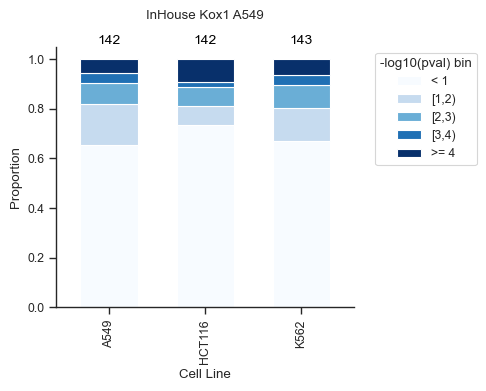

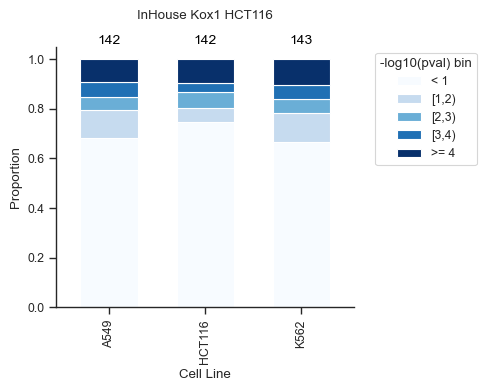

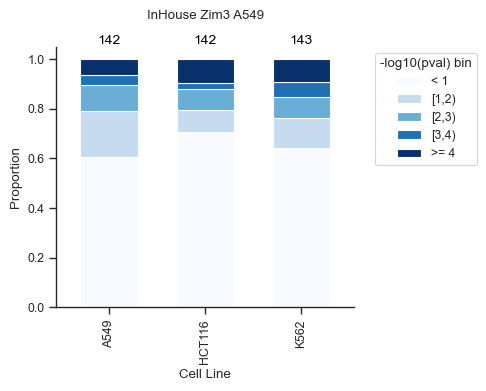

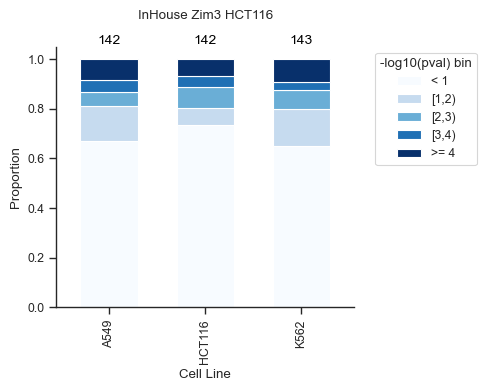

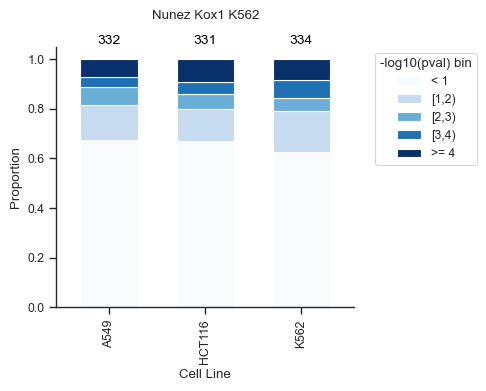

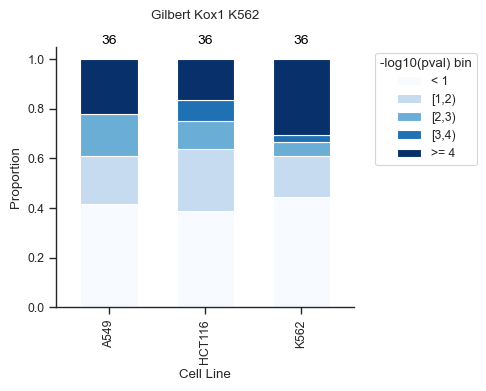

In [119]:
for selectData in allDataCount['DataSetID'].unique():
    select_count = allDataCount[allDataCount.DataSetID == selectData].copy()

    grouped_df = select_count.groupby(['-log10(pval) bins', 'DHS'])['counts'].sum().unstack().fillna(0)

    # Calculate percentages
    grouped_df_percentage = grouped_df.transpose().divide(grouped_df.sum(axis=0), axis=0)
    grouped_df_percentage = grouped_df_percentage[['< 1','[1,2)',  '[2,3)','[3,4)','>= 4']]
    # Plotting
    fig, ax = plt.subplots(figsize=(5, 4))

    grouped_df_percentage.plot(kind='bar', stacked=True, ax=ax, width=0.6, cmap = 'Blues', edgecolor = None)

     # Add percentages to the bars and the total count
    for i in range(grouped_df_percentage.shape[0]):
        total = 0
        totalCount = grouped_df.iloc[:, i].sum()  # Calculate the total count for each stack
        # Add total count text on top of each stack
        ax.text(i, 1.05, f'{int(totalCount)}', ha='center', va='bottom', fontsize=10, fontweight='light', color='black')

    plt.ylabel('Proportion')
    plt.xlabel('Cell Line')
    plt.title(selectData.replace('_',' '),pad=20)
    plt.legend(title='-log10(pval) bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    sns.despine()
    gpp.savefig(figure3_outpath + selectData + "_DHS_stacked_barplot.pdf", dpi=300, bbox_inches='tight')
    plt.show()